In [1]:
# !pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LSTM

## Data Loading

In [3]:
# X_train_scaled = pd.read_pickle('data/X_train_scaled.pkl')
# X_test_scaled = pd.read_pickle('data/X_test_scaled.pkl')
X_train_scaled = pd.read_pickle('data/X_train_final.pkl')
X_test_scaled = pd.read_pickle('data/X_test_final.pkl')
y_train_common = pd.read_pickle('data/y_train_common.pkl')
y_train_motor = pd.read_pickle('data/y_train_motor.pkl')
y_train_total = pd.read_pickle('data/y_train_total.pkl')
y_test_common = pd.read_pickle('data/y_test_common.pkl')
y_test_motor = pd.read_pickle('data/y_test_motor.pkl')
y_test_total = pd.read_pickle('data/y_test_total.pkl')

## Neural Netwrok

### Common Target

In [4]:
def r2_score(y_true, y_pred):
    ss_total = K.sum(K.square(y_true - K.mean(y_true)))
    ss_res = K.sum(K.square(y_true - y_pred))
    return (1 - ss_res / (ss_total + K.epsilon()))


#### Model 1

In [5]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='linear') )  # 2 outputs: motor_UPDRS and total_UPDRS

/Users/nicolajhoncharov/Documents/key_areas_2_faraci/assignment_1/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[r2_score])

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

In [8]:
history = model.fit(X_train_scaled, y_train_common, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test_common),
                    callbacks=[lr_scheduler, early_stopping], verbose=1)

Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 759.7843 - r2_score: -5.5971 - val_loss: 585.7604 - val_r2_score: -26.6911 - learning_rate: 0.0010
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 592.3101 - r2_score: -4.3864 - val_loss: 377.3227 - val_r2_score: -15.7935 - learning_rate: 0.0010
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 295.8436 - r2_score: -1.7081 - val_loss: 170.5947 - val_r2_score: -5.0603 - learning_rate: 0.0010
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 104.2027 - r2_score: 0.0232 - val_loss: 104.1623 - val_r2_score: -2.4716 - learning_rate: 0.0010
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 48.2862 - r2_score: 0.5630 - val_loss: 101.9817 - val_r2_score: -3.4379 - learning_rate: 0.0010
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 43.5226 - r2_score: 0.5980 - val_loss: 81.1585 - val_r2_score: -1.9486 - learning_rate: 0.0010
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━

In [9]:
test_loss = model.evaluate(X_test_scaled, y_test_common)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 147.5133 - r2_score: -2.8554


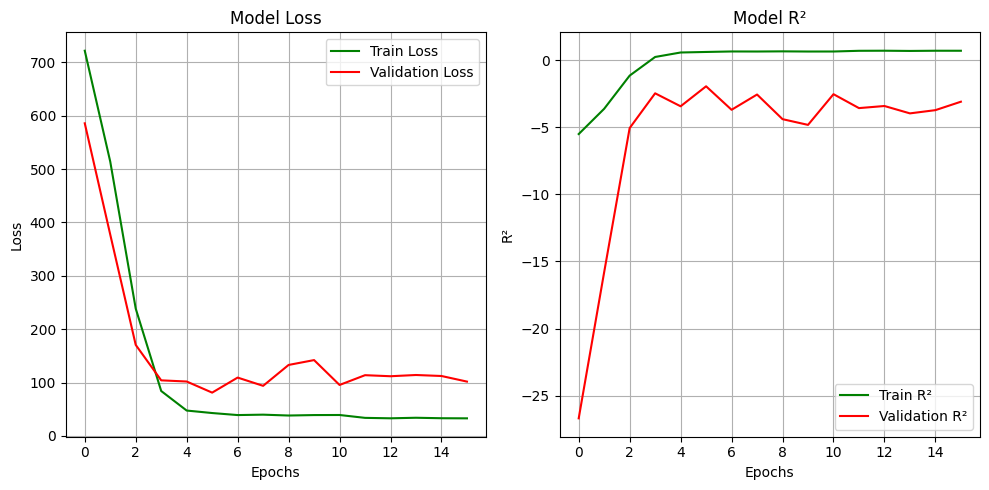

In [10]:
rcParams['figure.figsize'] = 10, 5

fig, ax = plt.subplots(1, 2)

ax[0].plot(history.history['loss'], 'g', label='Train Loss')
ax[0].plot(history.history['val_loss'], 'r', label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend(loc='upper right')
ax[0].grid(True)

ax[1].plot(history.history['r2_score'], 'g', label='Train R²')
ax[1].plot(history.history['val_r2_score'], 'r', label='Validation R²')
ax[1].set_title('Model R²')
ax[1].set_ylabel('R²')
ax[1].set_xlabel('Epochs')
ax[1].legend(loc='lower right')
ax[1].grid(True)

plt.tight_layout()
plt.show()

#### Model 2

In [11]:
model2 = Sequential()
model2.add(LSTM(128, input_shape=(X_train_scaled.shape[1], 1), activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='linear'))  # Single output for motor_UPDRS
model2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[r2_score])

/Users/nicolajhoncharov/Documents/key_areas_2_faraci/assignment_1/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
history2 = model2.fit(X_train_scaled, y_train_motor, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test_motor),
                    callbacks=[lr_scheduler, early_stopping], verbose=1)

Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 545.2554 - r2_score: -6.5382 - val_loss: 398.5430 - val_r2_score: -283.6758 - learning_rate: 0.0010
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 632.8444 - r2_score: -8.4886 - val_loss: 387.9356 - val_r2_score: -275.2067 - learning_rate: 0.0010
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 432.2115 - r2_score: -5.2631 - val_loss: 55.7939 - val_r2_score: -30.8840 - learning_rate: 0.0010
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 103.9698 - r2_score: -0.5352 - val_loss: 42.1645 - val_r2_score: -52.7998 - learning_rate: 0.0010
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 87.0195 - r2_score: -0.2073 - val_loss: 51.7819 - val_r2_score: -67.2129 - learning_rate: 0.0010
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 81.3679 - r2_score: -0.1683 - val_loss: 31.9526 - val_r2_score: -30.4928 - learning_rate: 0.0010
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [13]:
test_loss2 = model2.evaluate(X_test_scaled, y_test_motor)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 41.2591 - r2_score: -40.1146


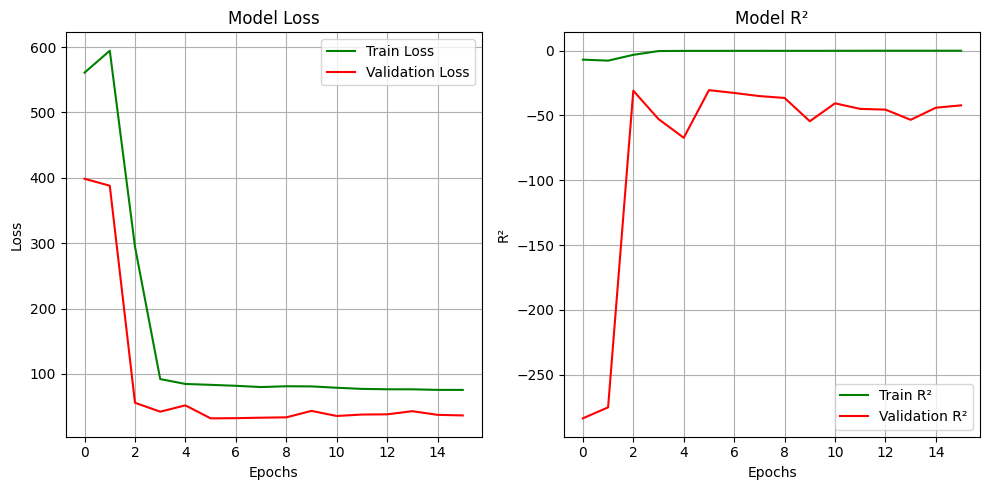

In [14]:
rcParams['figure.figsize'] = 10, 5
fig, ax = plt.subplots(1, 2)
ax[0].plot(history2.history['loss'], 'g', label='Train Loss')
ax[0].plot(history2.history['val_loss'], 'r', label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend(loc='upper right')
ax[0].grid(True)
ax[1].plot(history2.history['r2_score'], 'g', label='Train R²')
ax[1].plot(history2.history['val_r2_score'], 'r', label='Validation R²')
ax[1].set_title('Model R²')
ax[1].set_ylabel('R²')
ax[1].set_xlabel('Epochs')
ax[1].legend(loc='lower right')
ax[1].grid(True)
plt.tight_layout()
plt.show()

### Seperate Targets

#### motor_UPDRS

In [15]:
motor_model = Sequential()
motor_model.add(Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
motor_model.add(BatchNormalization())
motor_model.add(Dropout(0.3))
motor_model.add(Dense(128, activation='relu'))
motor_model.add(BatchNormalization())
motor_model.add(Dropout(0.3))
motor_model.add(Dense(64, activation='relu'))
motor_model.add(BatchNormalization())
motor_model.add(Dense(1, activation='linear')) 

/Users/nicolajhoncharov/Documents/key_areas_2_faraci/assignment_1/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
motor_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[r2_score])

In [17]:
early_stopping_motor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler_motor = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)


In [18]:
history_motor = motor_model.fit(X_train_scaled, y_train_motor, epochs=100, batch_size=32,
                    validation_data=(X_test_scaled, y_test_motor),
                    callbacks=[lr_scheduler_motor, early_stopping_motor], verbose=1)

Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 515.0725 - r2_score: -6.5215 - val_loss: 359.4410 - val_r2_score: -257.3613 - learning_rate: 0.0010
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 362.7186 - r2_score: -4.2326 - val_loss: 216.7669 - val_r2_score: -158.9911 - learning_rate: 0.0010
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161.6743 - r2_score: -1.2048 - val_loss: 98.3283 - val_r2_score: -76.4252 - learning_rate: 0.0010
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 51.0390 - r2_score: 0.2422 - val_loss: 80.3463 - val_r2_score: -55.0157 - learning_rate: 0.0010
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34.2068 - r2_score: 0.5122 - val_loss: 55.5232 - val_r2_score: -37.3426 - learning_rate: 0.0010
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.9093 - r2_score: 0.5584 - val_loss: 59.7444 - val_r2_score: -50.1433 - learning_rate: 0.0010
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

In [19]:
motor_test_loss = motor_model.evaluate(X_test_scaled, y_test_motor)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 83.8953 - r2_score: -66.9241


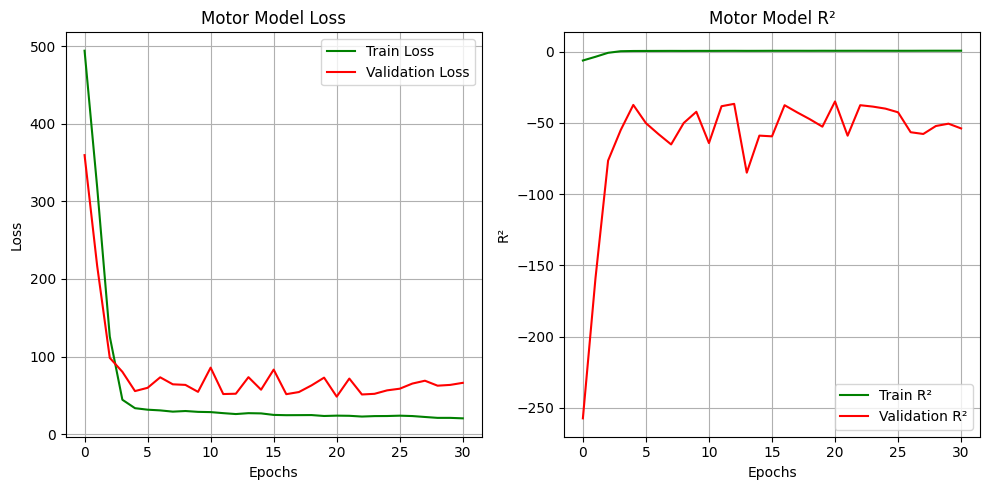

In [20]:
rcParams['figure.figsize'] = 10, 5
fig, ax = plt.subplots(1, 2)
ax[0].plot(history_motor.history['loss'], 'g', label='Train Loss')
ax[0].plot(history_motor.history['val_loss'], 'r', label='Validation Loss')
ax[0].set_title('Motor Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend(loc='upper right')
ax[0].grid(True)
ax[1].plot(history_motor.history['r2_score'], 'g', label='Train R²')
ax[1].plot(history_motor.history['val_r2_score'], 'r', label='Validation R²')
ax[1].set_title('Motor Model R²')
ax[1].set_ylabel('R²')
ax[1].set_xlabel('Epochs')
ax[1].legend(loc='lower right')
ax[1].grid(True)
plt.tight_layout()
plt.show()

#### total_UPDRS

In [21]:
total_model = Sequential()
total_model.add(Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
total_model.add(BatchNormalization())
total_model.add(Dropout(0.3))
total_model.add(Dense(128, activation='relu'))
total_model.add(BatchNormalization())
total_model.add(Dropout(0.3))
total_model.add(Dense(64, activation='relu'))
total_model.add(BatchNormalization())
total_model.add(Dense(1, activation='linear'))

/Users/nicolajhoncharov/Documents/key_areas_2_faraci/assignment_1/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
total_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[r2_score])

In [23]:
early_stopping_total = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler_total = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

In [24]:
history_total = total_model.fit(X_train_scaled, y_train_total, epochs=100, batch_size=32,
                    validation_data=(X_test_scaled, y_test_total),
                    callbacks=[lr_scheduler_total, early_stopping_total], verbose=1)

Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 962.8369 - r2_score: -7.2495 - val_loss: 748.2589 - val_r2_score: -265.1297 - learning_rate: 0.0010
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 762.9053 - r2_score: -5.3878 - val_loss: 426.1047 - val_r2_score: -138.0818 - learning_rate: 0.0010
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 417.2444 - r2_score: -2.4197 - val_loss: 371.7279 - val_r2_score: -131.9281 - learning_rate: 0.0010
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 157.1065 - r2_score: -0.2853 - val_loss: 147.3936 - val_r2_score: -39.5995 - learning_rate: 0.0010
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 66.1034 - r2_score: 0.4503 - val_loss: 135.1345 - val_r2_score: -30.1221 - learning_rate: 0.0010
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 56.7213 - r2_score: 0.5228 - val_loss: 148.3196 - val_r2_score: -62.1913 - learning_rate: 0.0010
Epoch 7/100
135/135 ━━━━━━━━━━━

In [25]:
total_test_loss = total_model.evaluate(X_test_scaled, y_test_total)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 205.9325 - r2_score: -40.2432


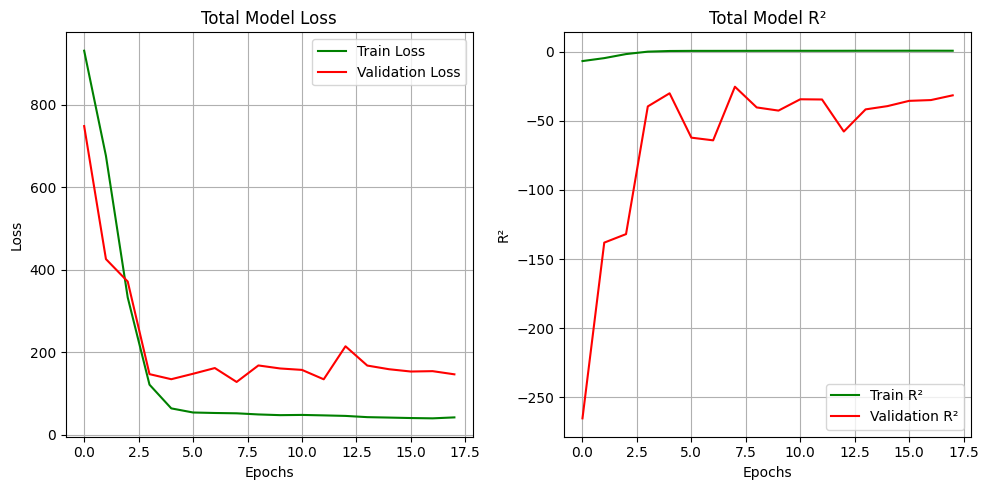

In [26]:
rcParams['figure.figsize'] = 10, 5
fig, ax = plt.subplots(1, 2)
ax[0].plot(history_total.history['loss'], 'g', label='Train Loss')
ax[0].plot(history_total.history['val_loss'], 'r', label='Validation Loss')
ax[0].set_title('Total Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend(loc='upper right')
ax[0].grid(True)
ax[1].plot(history_total.history['r2_score'], 'g', label='Train R²')
ax[1].plot(history_total.history['val_r2_score'], 'r', label='Validation R²')
ax[1].set_title('Total Model R²')
ax[1].set_ylabel('R²')
ax[1].set_xlabel('Epochs')
ax[1].legend(loc='lower right')
ax[1].grid(True)
plt.tight_layout()
plt.show()